# Introduction to Turing

## Introduction
This is the first of a series of tutorials on the universal probabilistic programming language **Turing**.

**Turing** is probabilistic programming system written entirely in *Julia*. It has an intuitive modelling syntax and supports a wide range of sampling-based inference algorithms. Most importantly, **Turing** inference is composable: it combines Markov chain sampling operations on subsets of model variables, e.g. using a combination of a Hamiltonian Monte Carlo (HMC) engine and a particle Gibbs (PG) engine. This composable inference engine allows the user to easily switch between black-box style inference methods such as HMC and customized inference methods.
 
Familiarity with Julia is assumed through out this tutorial. If you are new to Julia, [Learning Julia](https://julialang.org/learning/) is a good starting point.

For users new to Bayesian machine learning, please consider more thorough introductions to the field, such as [Pattern Recognition and Machine Learning](https://www.springer.com/us/book/9780387310732). This tutorial tries to provide an intuition for Bayesian inference and gives a simple example on how to use **Turing**. Note that this is not a comprehensive introduction to Bayesian machine learning.

### Coin-Flipping Without Turing
The following example illustrates the effect of updating our beliefs with every piece of new evidence we observe. In particular, assume that we are unsure about the probability of heads in a coin flip. To get an intuitive understanding of what "updating our beliefs" is, we will visualize the probability of heads in a coin flip after each observed evidence.

First, let's load some of the packages we need to flip a coin (`Random`, `Distributions`) and show our results (`Plots`). You will note that **Turing** is not an import here — we do not need it for this example. If you are already familiar with posterior updates, you can proceed to the next step.

In [1]:
# Using Base modules.
using Random

# Load a plotting library.
using Plots

# Load the distributions library.
using Distributions

Next, we configure our posterior update model. First, let's set the true probability that any coin flip will turn up heads and set the number of coin flips we will show our model:

In [2]:
# Set the true probability of heads in a coin.
p_true = 0.5

# Iterate from having seen 0 observations to 100 observations.
Ns = 0:100;

We will now use the Bernoulli distribution to flip 100 coins, and collect the results in a variable called `data`:

In [3]:
# Draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(12)
data = rand(Bernoulli(p_true), last(Ns))

# Here's what the first five coin flips look like:
data[1:5]

5-element Array{Int64,1}:
 1
 0
 1
 1
 0

After flipping all our coins, we want to set a prior belief about what we think the distribution of coin flips look like. In this case, we are going to choose a common prior distribution called the [Beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution.

In [4]:
# Our prior belief about the probability of heads in a coin toss.
prior_belief = Beta(1, 1);

With our priors set and our data at hand, we can perform Bayesian inference.

This is a fairly simple process. We expose one additional coin flip to our model every iteration, such that the first run only sees the first coin flip, while the last iteration sees all the coin flips. Then, we set the `updated_belief` variable to an updated version of the original Beta distribution that accounts for the new proportion of heads and tails. 

For the mathematically inclined, the `Beta` distribution is updated by adding each coin flip to the distribution's $\alpha$ and $\beta$ parameters, which are initially defined as $\alpha = 1, \beta = 1$. Over time, with more and more coin flips, $\alpha$ and $\beta$ will be approximately equal to each other as we are equally likely to flip a heads or a tails, and the plot of the beta distribution will become more tightly centered around 0.5. 

This works because mean of the `Beta` distribution is defined as the following:

$$ \text{E}[\text{Beta}] = \dfrac{\alpha}{\alpha+\beta} $$

Which is 0.5 when $\alpha = \beta$, as we expect for a large enough number of coin flips. As we increase the number of samples, our variance will also decrease, such that the distribution will reflect less uncertainty about the probability of receiving a heads. The definition of the variance for the `Beta` distribution is the following:

$$ \text{var}[\text{Beta}] = \dfrac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} $$

The intuition about this definition is that the variance of the distribution will approach 0 with more and more samples, as the denominator will grow faster than will the numerator. More samples means less variance.

In [5]:
# Import StatsPlots for animating purposes.
using StatsPlots

# Make an animation.
animation = @gif for (i, N) in enumerate(Ns)

    # Count the number of heads and tails.
    heads = sum(data[1:i-1])
    tails = N - heads
    
    # Update our prior belief in closed form (this is possible because we use a conjugate prior).
    updated_belief = Beta(prior_belief.α + heads, prior_belief.β + tails)

    # Plotting
    plot(updated_belief, 
        size = (500, 250), 
        title = "Updated belief after $N observations",
        xlabel = "probability of heads", 
        ylabel = "", 
        legend = nothing,
        xlim = (0,1),
        fill=0, α=0.3, w=3)
    vline!([p_true])
end;

![animation](https://user-images.githubusercontent.com/7974003/44995702-37c1b200-af9c-11e8-8b26-c88a528956af.gif)

The animation above shows that with increasing evidence our belief about the probability of heads in a coin flip slowly adjusts towards the true value. The orange line in the animation represents the true probability of seeing heads on a single coin flip, while the mode of the distribution shows what the model believes the probability of a heads is given the evidence it has seen.

### Coin Flipping With Turing

In the previous example, we used the fact that our prior distribution is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). Note that a closed-form expression (the `updated_belief` expression) for the posterior is not accessible in general and usually does not exist for more interesting models. 

We are now going to move away from the closed-form expression above and specify the same model using **Turing**. To do so, we will first need to import `Turing`, `MCMCChain`, `Distributions`, and `StatPlots`. `MCMChain` is a library built by the Turing team to help summarize Markov Chain Monte Carlo (MCMC) simulations, as well as a variety of utility functions for diagnostics and visualizations.

In [6]:
# Load Turing and MCMCChain.
using Turing, MCMCChain

# Load the distributions library.
using Distributions

# Load stats plots for density plots.
using StatsPlots

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1186


First, we define the coin-flip model using Turing.

In [7]:
@model coinflip(y) = begin
    
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)
    
    # The number of observations.
    N = length(y)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        y[n] ~ Bernoulli(p)
    end
end;

After defining the model, we can approximate the posterior distribution by drawing samples from the distribution. In this example, we use a [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) sampler to draw these samples. Later tutorials will give more information on the samplers available in Turing and discuss their use for different models.

In [8]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(coinflip(data), HMC(iterations, ϵ, τ));

[HMC] Sampling...  0%  ETA: 1:13:14
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 39%  ETA: 0:00:09
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 63%  ETA: 0:00:04
  ϵ:         0.05
  α:         0.994690509167363
4m  pre_cond:  [1.0]


[HMC] Sampling... 90%  ETA: 0:00:01
  ϵ:         0.05
  α:         0.9986516215404824
4m  pre_cond:  [1.0]


[HMC] Sampling...100% Time: 0:00:08


[HMC] Finished with
  Running time        = 7.922578884999986;
  Accept rate         = 0.997;
  #lf / sample        = 9.99;
  #evals / sample     = 11.99;
  pre-cond. metric    = [1.0].


After finishing the sampling process, we can visualize the posterior distribution approximated using Turing against the posterior distribution in closed-form. We can extract the chain data from the sampler using the `Chains(chain[:p])` function, exported from the `MCMCChain` module. `Chains(chain[:p])` creates an instance of the `Chain` type which summarizes the MCMC simulation — the `MCMCChain` module supports numerous tools for plotting, summarizing, and describing variables of type `Chain`.

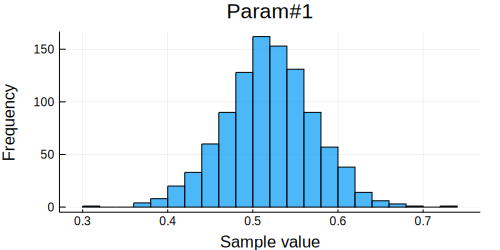

In [9]:
# Construct summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
p_summary = Chains(chain[:p])
plot(p_summary, seriestype = :histogram)

Now we can build our plot:

In [10]:
# Compute the posterior distribution in closed-form.
N = length(data)
heads = sum(data)
updated_belief = Beta(prior_belief.α + heads, prior_belief.β + N - heads)

# Visualize a blue density plot of the approximate posterior distribution using HMC (see Chain 1 in the legend).
p = plot(p_summary, seriestype = :density, xlim = (0,1), legend = :best, w = 2, c = :blue)

# Visualize a green density plot of posterior distribution in closed-form.
plot!(p, range(0, stop = 1, length = 100), pdf.(Ref(updated_belief), range(0, stop = 1, length = 100)), 
        xlabel = "probability of heads", ylabel = "", title = "", xlim = (0,1), label = "Closed-form",
        fill=0, α=0.3, w=3, c = :lightgreen)

# Visualize the true probability of heads in red.
vline!(p, [p_true], label = "True probability", c = :red);

![sdf](https://user-images.githubusercontent.com/7974003/44995682-25477880-af9c-11e8-850b-36e4b6d756ea.png)

As we can see, the Turing model closely approximates the true probability. Hopefully this tutorial has provided an easy-to-follow, yet informative introduction to Turing's simpler applications. More advanced usage will be demonstrated in later tutorials.